In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import ast
import re

# Load the data
df = pd.read_csv('prosumer_stats.csv')
df_blockchain = pd.read_csv('blockchain_stats.csv')

# Function to parse the transactions string
def parse_transactions(trans_str):
    if pd.isna(trans_str):
        return []
    try:
        return ast.literal_eval(trans_str)
    except:
        return []

df['transactions_list'] = df['transactions'].apply(parse_transactions)

# Create a mapping of ID to neighbourhood for later use
id_to_hood = df.set_index('id')['neighbourhood'].to_dict()

df.head()

,hour,id,pv_capacity,pv_generation,load,battery_capacity,battery_level,imbalance,money_balance,trading_price,neighbourhood,bonus,penalty,p2p_exchanges,agg_exchanges,market_price,transactions,transactions_list
0,0,2,2.75,-0.012732,0.412072,0,0.0,0.0,-51.784216,123.970380,Lingotto,1.0,1.0,0,1,116.096545,"[{'sender': 'Aggregator', 'receiver': 2, 'amou...","[{'sender': 'Aggregator', 'receiver': 2, 'amou..."
1,0,3,0.50,-0.019339,0.391340,0,0.0,0.0,-50.062411,110.308125,Lingotto,1.0,1.0,0,1,116.096545,"[{'sender': 'Aggregator', 'receiver': 3, 'amou...","[{'sender': 'Aggregator', 'receiver': 3, 'amou..."
2,0,6,3.75,-0.007015,0.394570,0,0.0,0.0,-48.953764,112.718191,Lingotto,1.0,1.0,0,1,116.096545,"[{'sender': 'Aggregator', 'receiver': 6, 'amou...","[{'sender': 'Aggregator', 'receiver': 6, 'amou..."
3,0,10,0.00,-0.016746,0.246145,10,0.0,0.0,-32.046722,106.867365,Lingotto,1.0,1.0,0,1,116.096545,"[{'sender': 'Aggregator', 'receiver': 10, 'amo...","[{'sender': 'Aggregator', 'receiver': 10, 'amo..."
4,0,11,3.75,-0.008029,0.197098,0,0.0,0.0,-25.005330,106.338306,Lingotto,1.0,1.0,0,1,116.096545,"[{'sender': 'Aggregator', 'receiver': 11, 'amo...","[{'sender': 'Aggregator', 'receiver': 11, 'amo..."


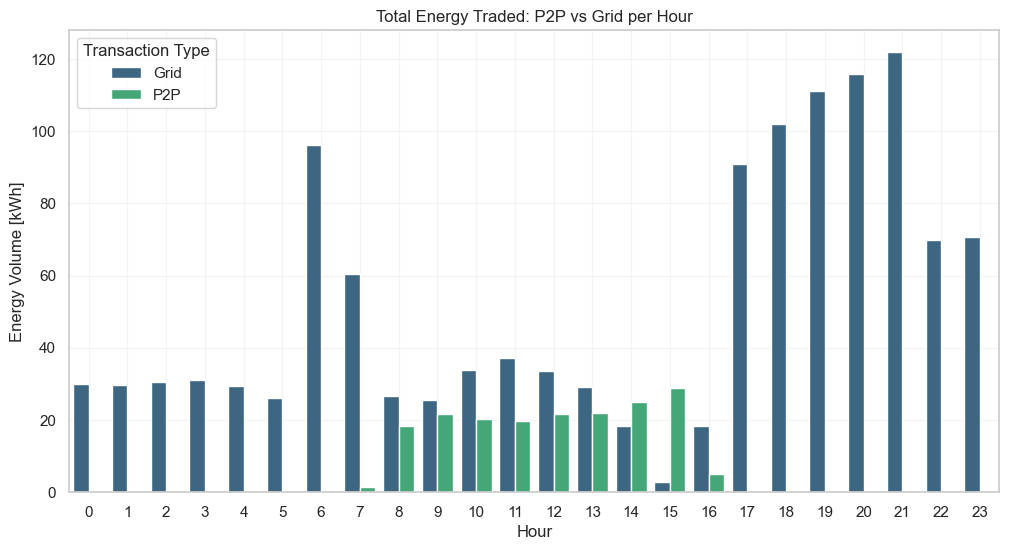

In [25]:
# Energy Flows (Global & Hourly)
# Visualize the total energy volume traded P2P vs. with the Grid/Aggregator per hour

# Aggregate transaction data
hourly_energy = {'hour': [], 'type': [], 'amount': []}

for index, row in df.iterrows():
    for t in row['transactions_list']:
        hourly_energy['hour'].append(t['hour'])
        if t['type'] == 'P2P':
            t_type = 'P2P'
        else:
            t_type = 'Grid'
        hourly_energy['type'].append(t_type)
        hourly_energy['amount'].append(t['amount'])

energy_df = pd.DataFrame(hourly_energy)
energy_summary = energy_df.groupby(['hour', 'type'])['amount'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=energy_summary, x='hour', y='amount', hue='type', palette='viridis')
plt.title('Total Energy Traded: P2P vs Grid per Hour')
plt.xlabel('Hour')
plt.ylabel('Energy Volume [kWh]')
plt.legend(title='Transaction Type')
plt.grid( alpha=0.2)
plt.show()

# Gemini comments:
# You will likely see P2P trading peak during daylight hours (e.g., 10:00 to 16:00) 
# when solar production is high. If the "Grid" bars are huge during the evening peak (18:00–21:00), 
# it means the community batteries/solar aren't enough to cover the night demand

# Success Indicator: If the P2P bars are visible and significant, your Step 2 (P2P Market) is working correctly.

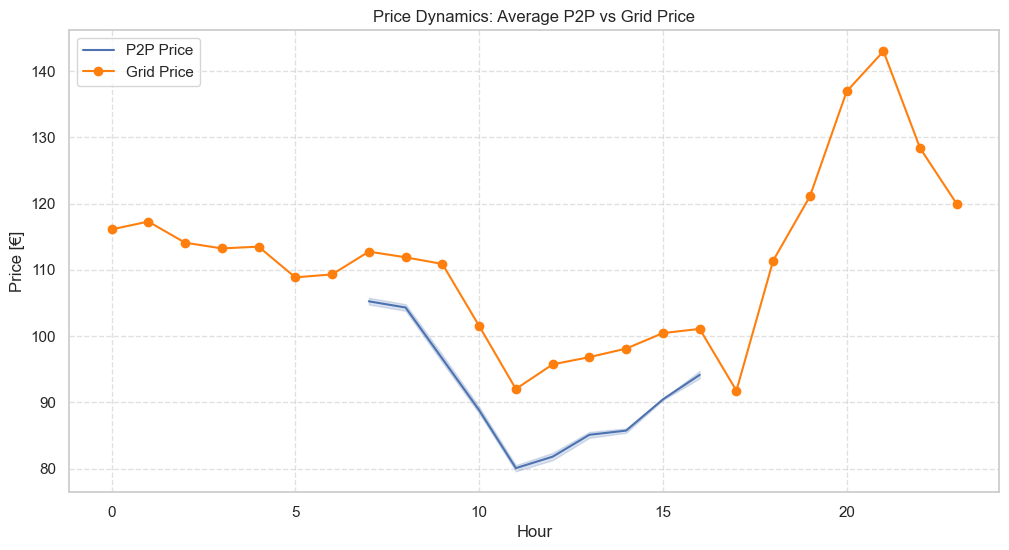

In [26]:
# Price Dynamics
# Compare the average P2P trading price against the Grid (Aggregator) price over time.
price_data = {'hour': [], 'price': [], 'market': []}

# 1. Get P2P Prices from transactions
for index, row in df.iterrows():
    for t in row['transactions_list']:
        if t['type'] == 'P2P':
            price_data['hour'].append(t['hour'])
            price_data['price'].append(t['price_per_kWh'])
            price_data['market'].append('P2P Price')

grid_prices = df['market_price'].groupby(df['hour']).mean().tolist()

price_df = pd.DataFrame(price_data)

plt.figure(figsize=(12, 6))
sns.lineplot(data=price_df, x='hour', y='price', markers=True, dashes=False , label='P2P Price')
plt.plot(range(24), grid_prices, label='Grid Price', marker='o' , color='tab:orange')
plt.title('Price Dynamics: Average P2P vs Grid Price')
plt.xlabel('Hour')
plt.ylabel('Price [€]')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Gemini comments:

# Economic Incentive: For P2P trading to be attractive, the P2P price line should generally be lower than the Grid Buy price 
# (what consumers pay the aggregator) and higher than the Grid Sell price (what producers get from the aggregator).

# Market Behavior: If the P2P price fluctuates (e.g., drops during the day when there is excess solar, rises at night), 
# it shows your market mechanism is responsive to supply and demand.

# Anomaly Check: If the P2P price is identical to the grid price, your pricing mechanism might be static or not functioning dynamically.

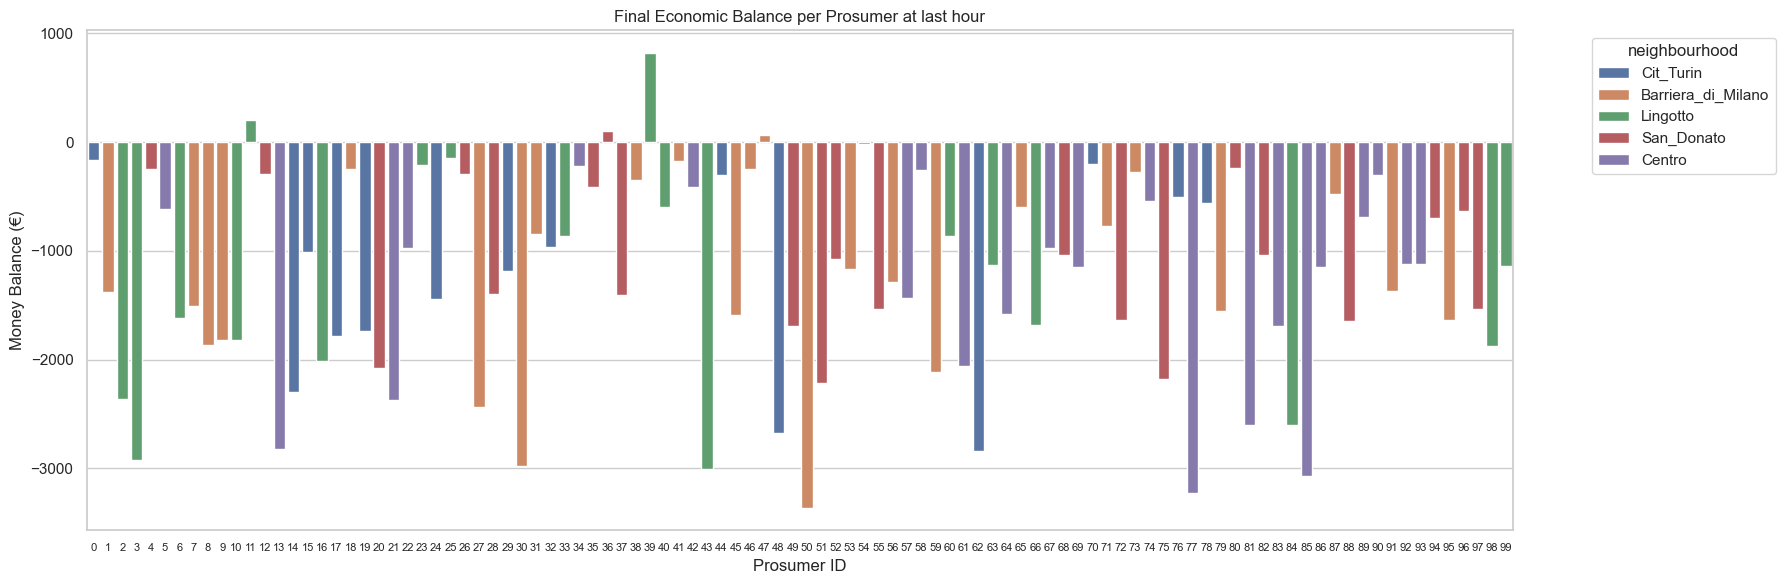

In [27]:
# Prosumer Economic Outcomes
# Show who made money and who lost money by the end of the simulation.

# final state (last hour) for each prosumer
last_hour = df['hour'].max()
final_stats = df[df['hour'] == last_hour].sort_values('money_balance')

plt.figure(figsize=(18, 6))
# color bars by neighbourhood
sns.barplot(data=final_stats, x='id', y='money_balance', hue='neighbourhood', dodge=False)
plt.title(f'Final Economic Balance per Prosumer at last hour')
plt.xlabel('Prosumer ID')
plt.ylabel('Money Balance (€)')
plt.xticks(fontsize=8)
plt.legend(title='neighbourhood', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Gemini comments:
# Winners vs. Losers: Prosumers with high PV generation and batteries usually end up with positive bars (profit). 
# Pure consumers (no PV) will have negative bars (expenses).

# neighbourhood Trends: Since the bars are colored by neighbourhood, check if specific neighbourhoods 
# (e.g., "Crocetta" or "Vanchiglia") are performing better. This might indicate that one neighbourhood
# has better solar exposure or battery capacity in your simulation setup.

# Outliers: If one bar is massive compared to others, that agent might have huge capacity or
# be capitalizing on the market disproportionately.

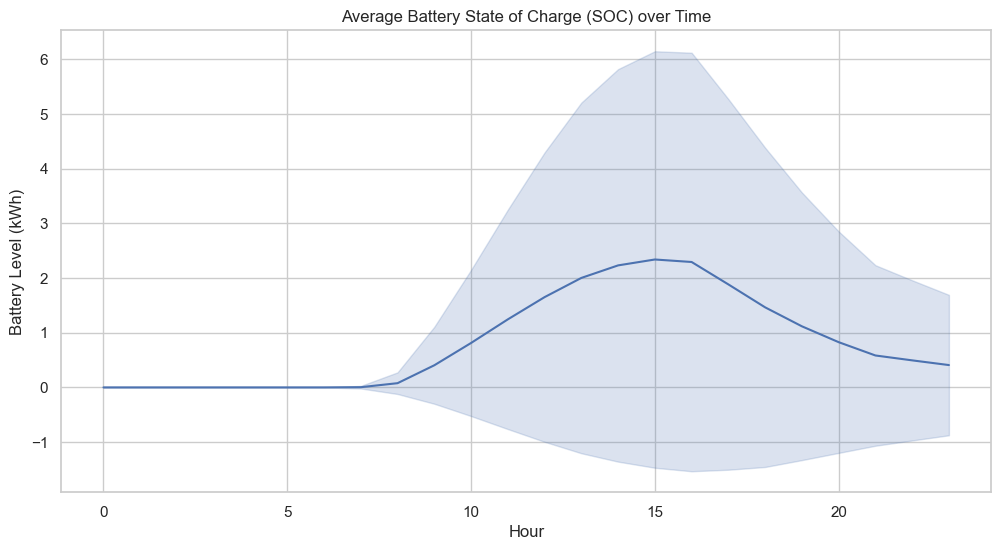

In [28]:
# Plotting average battery level with range (min-max)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour', y='battery_level', errorbar='sd') # sd = standard deviation
plt.title('Average Battery State of Charge (SOC) over Time')
plt.xlabel('Hour')
plt.ylabel('Battery Level (kWh)')
plt.grid(True)
plt.show()

# Gemini comments:
# Cycling: You should see a curve that starts low, 
# rises during the day (charging from solar), peaks around 14:00–16:00, and drops in the evening (discharging to support consumption).

# Utilization: If the line is flat near 0 or flat near 100% capacity, the batteries aren't being used effectively.

# Variability: Large error bars indicate that some prosumers are fully charged while others are empty, 
# suggesting an uneven distribution of resources.

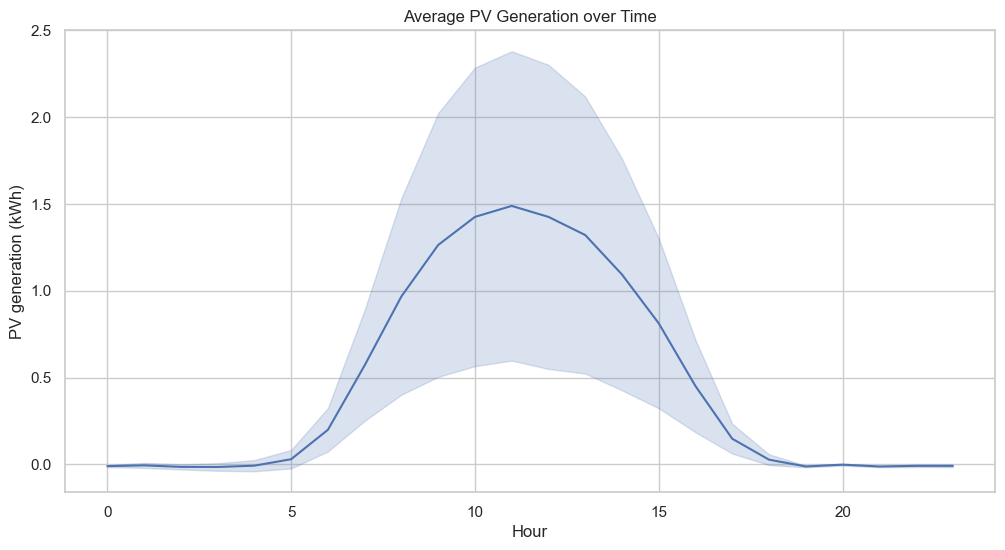

In [29]:
# Plotting average PV generation with range (min-max)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour', y='pv_generation', errorbar='sd') # sd = standard deviation
plt.title('Average PV Generation over Time')
plt.xlabel('Hour')
plt.ylabel('PV generation (kWh)')
plt.grid(True)
plt.show()

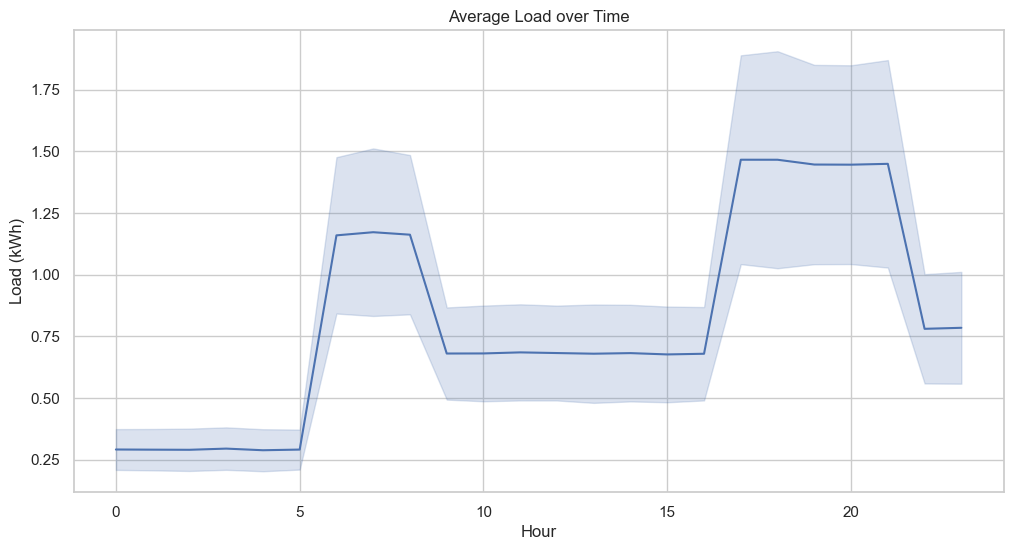

In [30]:
# Plotting average load with range (min-max)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour', y='load', errorbar='sd') # sd = standard deviation
plt.title('Average Load over Time')
plt.xlabel('Hour')
plt.ylabel('Load (kWh)')
plt.grid(True)
plt.show()

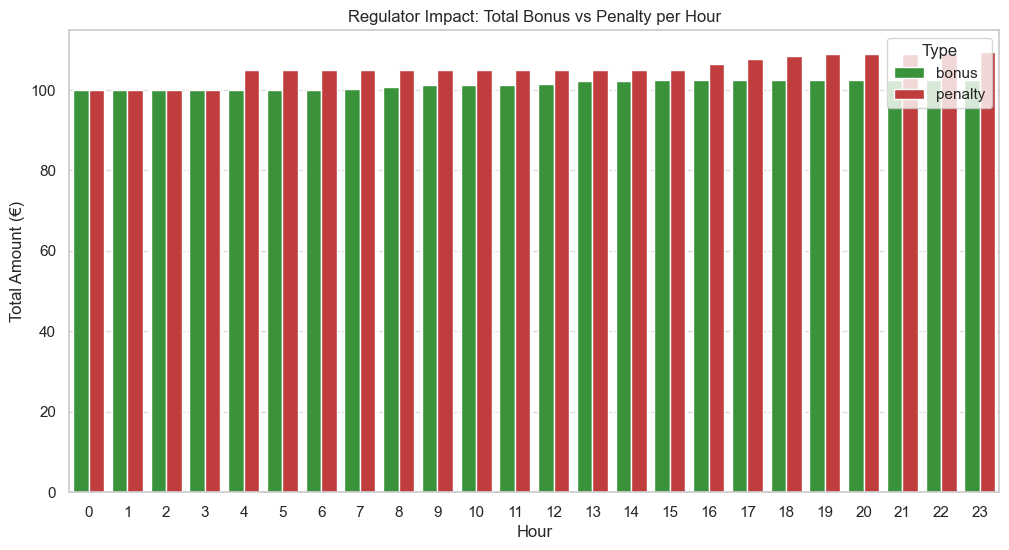

In [31]:
# Regulator Impact (Bonus vs Penalty)
# Visualize the financial incentives applied by the regulator

# Sum bonuses and penalties per hour
regulator_stats = df.groupby('hour')[['bonus', 'penalty']].sum().reset_index()
# Melt for plotting
regulator_melted = regulator_stats.melt('hour', var_name='Type', value_name='Amount')

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=regulator_melted, x='hour', y='Amount', hue='Type', palette=['tab:green', 'tab:red'])
plt.title('Regulator Impact: Total Bonus vs Penalty per Hour')
plt.xlabel('Hour')
plt.ylabel('Total Amount (€)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gemini comments:
# Rule Compliance:

# - High Penalties: This means prosumers are deviating significantly 
#       from their promised profiles (Step 1 prediction vs. Step 3 actuals). This suggests the prediction models might 
#       be inaccurate or the battery balancing logic isn't aggressive enough.

#  - High Bonuses: This means prosumers are helping the grid (e.g., increasing consumption when there is a surplus).

# Regulator Strategy: This plot confirms if the "Regulator" agent code is actually triggering and applying financial consequences as intended.

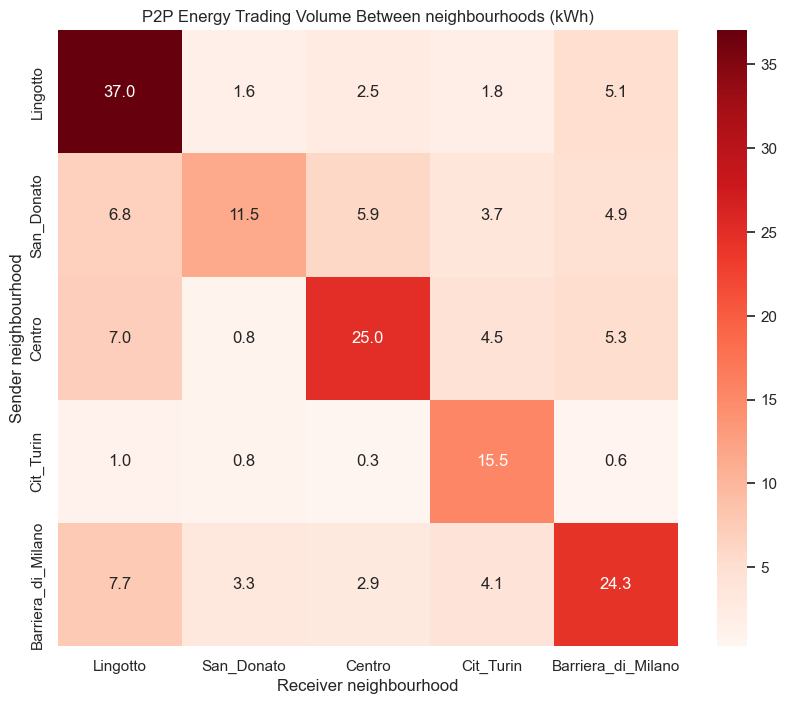

In [32]:
# neighbourhood Trading Heatmap
# See which neighbourhoods are trading with each other (P2P)

neighbourhoods = df['neighbourhood'].unique()
# Create a square DataFrame initialized with zeros
trade_matrix = pd.DataFrame(0.0, index=neighbourhoods, columns=neighbourhoods)

# Fill matrix with P2P trade volumes
for index, row in df.iterrows():
    sender_hood = row['neighbourhood']
    transactions = row['transactions_list']
    
    for t in transactions:
        if t['type'] == 'P2P':
            receiver_id = t['receiver']
            amount = t['amount']
            
            # Find receiver's neighbourhood
            if receiver_id in id_to_hood:
                receiver_hood = id_to_hood[receiver_id]
                # Add to matrix (Rows = Senders, Cols = Receivers)
                trade_matrix.loc[sender_hood, receiver_hood] += amount

plt.figure(figsize=(10, 8))
sns.heatmap(trade_matrix, annot=True, cmap='Reds', fmt='.1f')
plt.title('P2P Energy Trading Volume Between neighbourhoods (kWh)')
plt.xlabel('Receiver neighbourhood')
plt.ylabel('Sender neighbourhood')
plt.show()

# Gemini comments:
# Diagonal: The diagonal squares (e.g., Centro to Centro) show energy traded within the same neighbourhood. This is often highest.

# Community Integration: Bright colors off the diagonal (e.g., Crocetta to Vanchiglia) prove that the "Smart City" concept 
# is working—energy is being shared across the entire city, not just within isolated pockets.

# Exporters vs. Importers: If a row is very dark (high values), that neighbourhood is a net producer (exporting energy). 
# If a column is dark, that neighbourhood is a net consumer (importing energy).

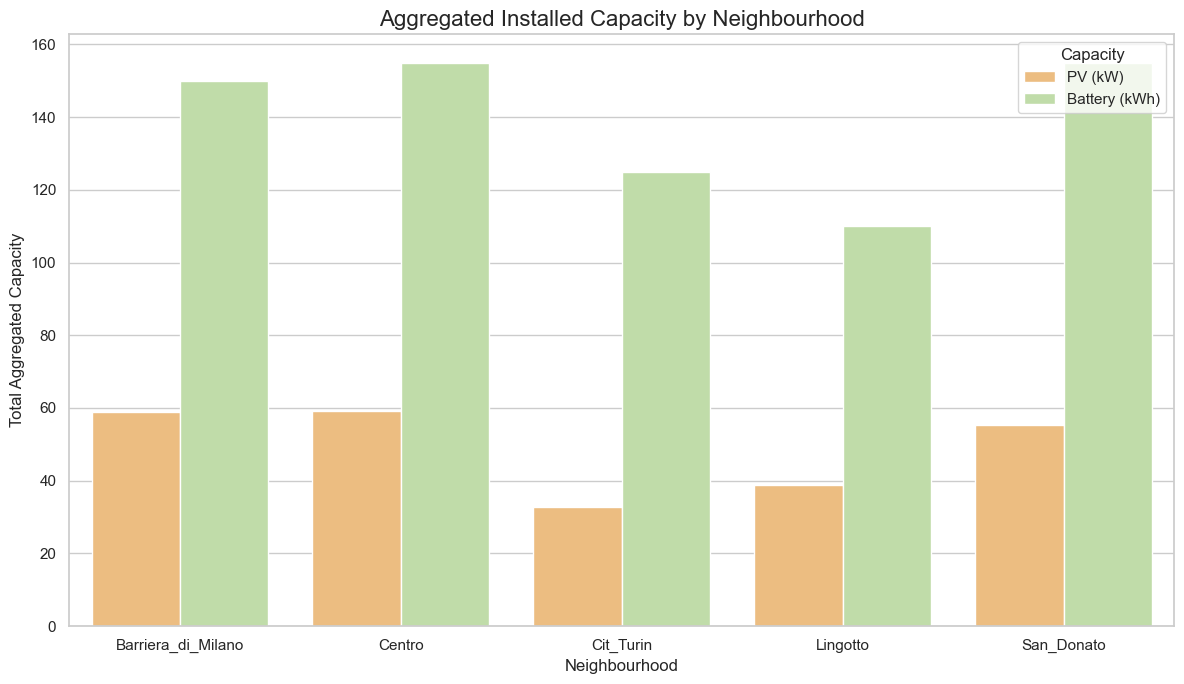

In [33]:
# Neighbourhood Statistics Plotting

# Step 1: Calculate the average capacity per prosumer ID
prosumer_stats = df.groupby('id')[['pv_capacity', 'battery_capacity']].mean().reset_index()

# Step 2: Map the neighbourhood back to the prosumer ID
id_to_neighbourhood = df[['id', 'neighbourhood']].drop_duplicates().set_index('id')['neighbourhood'].to_dict()
prosumer_stats['neighbourhood'] = prosumer_stats['id'].map(id_to_neighbourhood)

# Step 3: Sum the total installed capacity per neighbourhood
agg_stats = prosumer_stats.groupby('neighbourhood')[['pv_capacity', 'battery_capacity']].sum().reset_index()

# --- Plotting ---

# Melt the dataframe for easier plotting with seaborn
plot_df = agg_stats.melt(
    id_vars='neighbourhood', 
    var_name='Capacity', 
    value_name='Value'
)

# Rename metrics
plot_df['Capacity'] = plot_df['Capacity'].replace({
    'pv_capacity': 'PV (kW)',
    'battery_capacity': 'Battery (kWh)'
})

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# Create the grouped bar chart
sns.barplot(
    x='neighbourhood', 
    y='Value', 
    hue='Capacity', 
    data=plot_df,
    palette='Spectral'
)

# Customize the plot
plt.title('Aggregated Installed Capacity by Neighbourhood', fontsize=16)
plt.xlabel('Neighbourhood', fontsize=12)
plt.ylabel('Total Aggregated Capacity', fontsize=12)
plt.legend(title='Capacity', loc='upper right')
plt.tight_layout() 
plt.show()

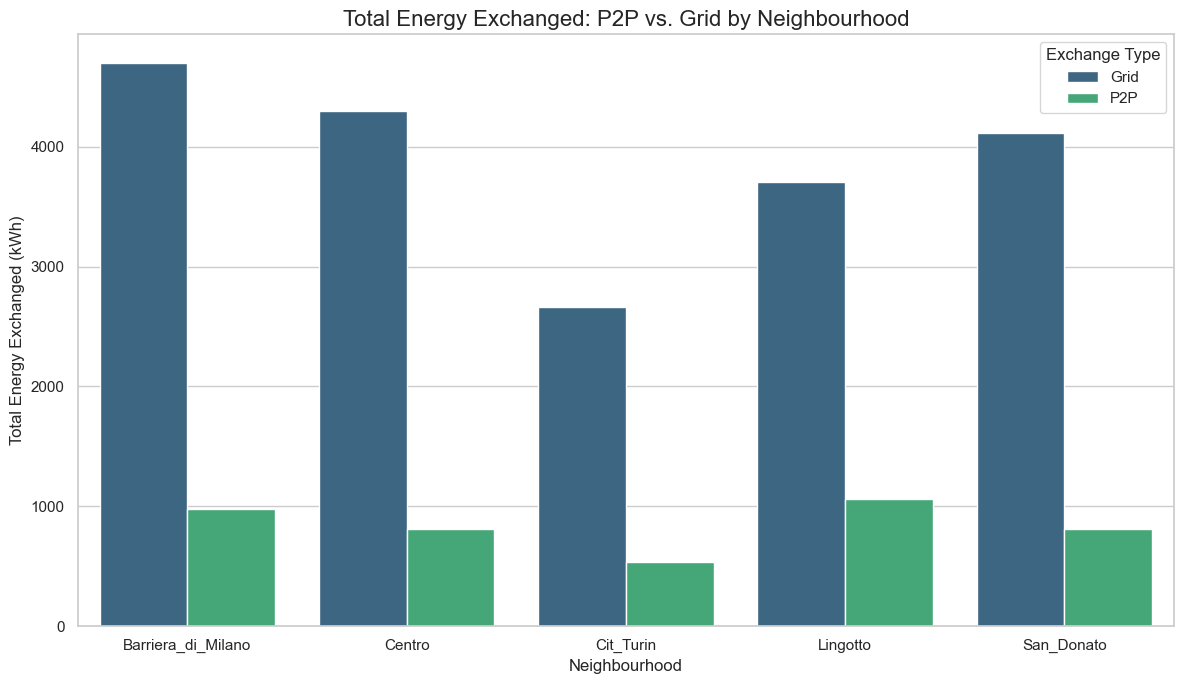

In [34]:
# Neighbourhood Energy Exchange Plotting

# 1. Aggregate the total exchanges by Neighbourhood
# Summing across all hours and prosumers in the neighbourhood
exchange_stats = df.groupby('neighbourhood')[['agg_exchanges', 'p2p_exchanges']].sum().reset_index()

# 2. Melt the dataframe for plotting
plot_df_exchange = exchange_stats.melt(
    id_vars='neighbourhood', 
    var_name='Exchange Type', 
    value_name='Energy Exchanged (kWh)'
)

# 3. Rename metrics
plot_df_exchange['Transaction Type'] = plot_df_exchange['Exchange Type'].replace({
    'agg_exchanges': 'Grid',
    'p2p_exchanges': 'P2P'
})

# --- Plotting ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.barplot(
    x='neighbourhood', 
    y='Energy Exchanged (kWh)', 
    hue='Transaction Type', 
    data=plot_df_exchange,
    palette='viridis'
)

# Customize the plot
plt.title('Total Energy Exchanged: P2P vs. Grid by Neighbourhood', fontsize=16)
plt.xlabel('Neighbourhood', fontsize=12)
plt.ylabel('Total Energy Exchanged (kWh)', fontsize=12)
plt.legend(title='Exchange Type', loc='upper right')
plt.tight_layout() 
plt.show()

In [35]:
df_blockchain

,hour,all_competitors,all_powers,winner_miner,winner_power,num_pending_transactions
0,0,"['Miner_Node_1', 'Miner_Node_2', 'Miner_Node_3...","[0.7790547902293906, 0.39503423081286104, 0.60...",Miner_Node_8,0.662719,100
1,1,"['Miner_Node_1', 'Miner_Node_2', 'Miner_Node_3...","[0.1917900184454498, 0.3974954772514342, 0.397...",Miner_Node_4,0.225291,100
2,2,"['Miner_Node_1', 'Miner_Node_2', 'Miner_Node_3...","[0.372418945781393, 0.11396203286913337, 0.277...",Miner_Node_8,0.985063,100
3,3,"['Miner_Node_1', 'Miner_Node_2', 'Miner_Node_3...","[0.5450951647024785, 0.777102039049296, 0.7463...",Miner_Node_5,0.806702,100
4,4,"['Miner_Node_1', 'Miner_Node_2', 'Miner_Node_3...","[0.5729077410924305, 0.6168644330027095, 0.462...",Miner_Node_4,0.502415,100
5,5,"['Miner_Node_1', 'Miner_Node_2', 'Miner_Node_3...","[0.7321101212419246, 0.8293811418943884, 0.406...",Miner_Node_8,0.498317,100
6,6,"['Miner_Node_1', 'Miner_Node_2', 'Miner_Node_3...","[0.2565443636942213, 0.18102224909501913, 0.89...",Miner_Node_3,0.892918,100
7,7,"['Miner_Node_1', 'Miner_Node_2', 'Miner_Node_3...","[0.5679259952773816, 0.1602899551456067, 0.807...",Miner_Node_5,0.821795,96
8,8,"['Miner_Node_1', 'Miner_Node_2', 'Miner_Node_3...","[0.9500727750908691, 0.37078889866703857, 0.96...",Miner_Node_9,0.748882,79
9,9,"['Miner_Node_1', 'Miner_Node_2', 'Miner_Node_3...","[0.9905928115024057, 0.82621722912361, 0.79152...",Miner_Node_9,0.847546,62


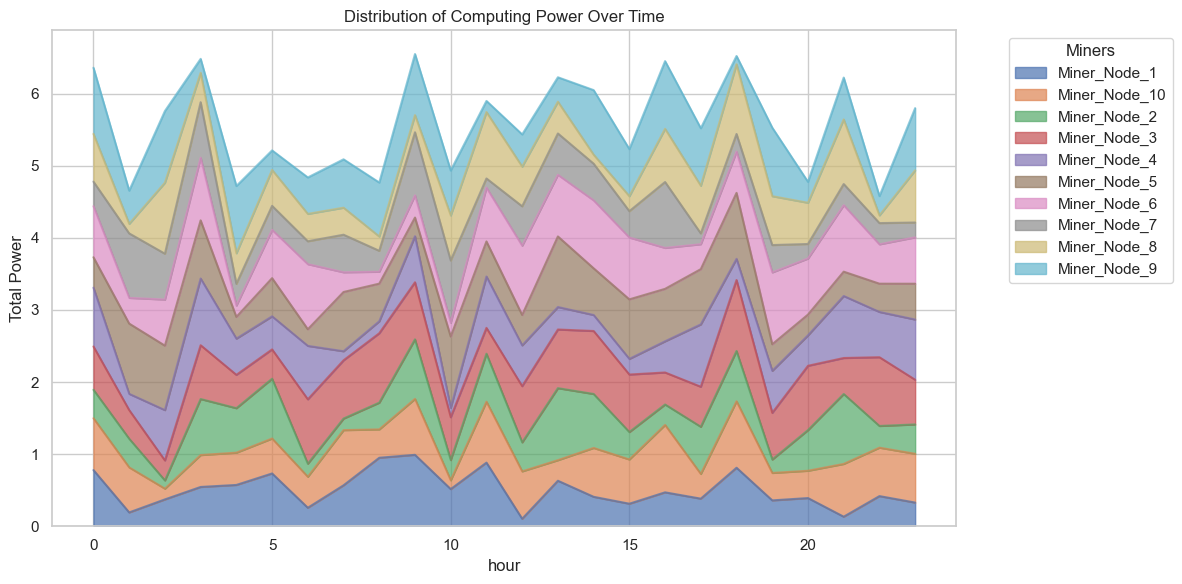

In [36]:
# Conversion because in the CSV the lists are saved as text
df_blockchain['all_competitors'] = df_blockchain['all_competitors'].apply(ast.literal_eval)
df_blockchain['all_powers'] = df_blockchain['all_powers'].apply(ast.literal_eval)

power_data = []
for _, row in df_blockchain.iterrows():
    for m, p in zip(row['all_competitors'], row['all_powers']):
        power_data.append({'hour': row['hour'], 'miner': m, 'power': p})

df_temp = pd.DataFrame(power_data)


df_power = df_temp.pivot_table(
    index='hour', columns='miner', values='power', aggfunc='sum'
).fillna(0)


# Plot the distribution of computing power over time
plt.figure(figsize=(12, 6))
df_power.plot(kind='area', stacked=True, alpha=0.7, ax=plt.gca())
plt.title("Distribution of Computing Power Over Time")
plt.legend(title="Miners", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("Total Power")
plt.tight_layout()
plt.show()

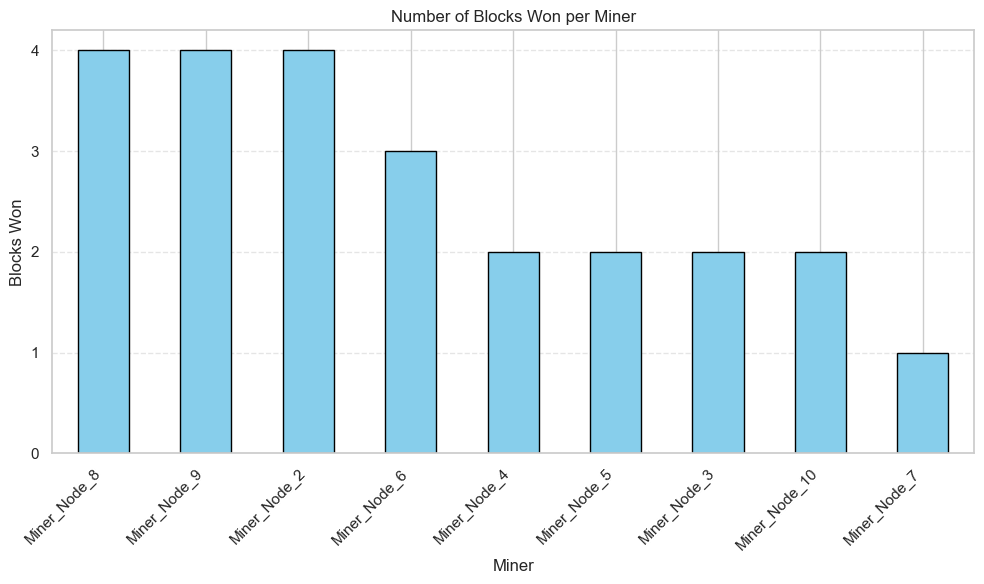

In [37]:
# Plot the number of blocks won per miner
plt.figure(figsize=(10, 6))
ax = df_blockchain['winner_miner'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # Ensure y-axis has integer ticks
plt.xticks(rotation=45, ha='right')
plt.title("Number of Blocks Won per Miner")
plt.xlabel("Miner")
plt.ylabel("Blocks Won")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

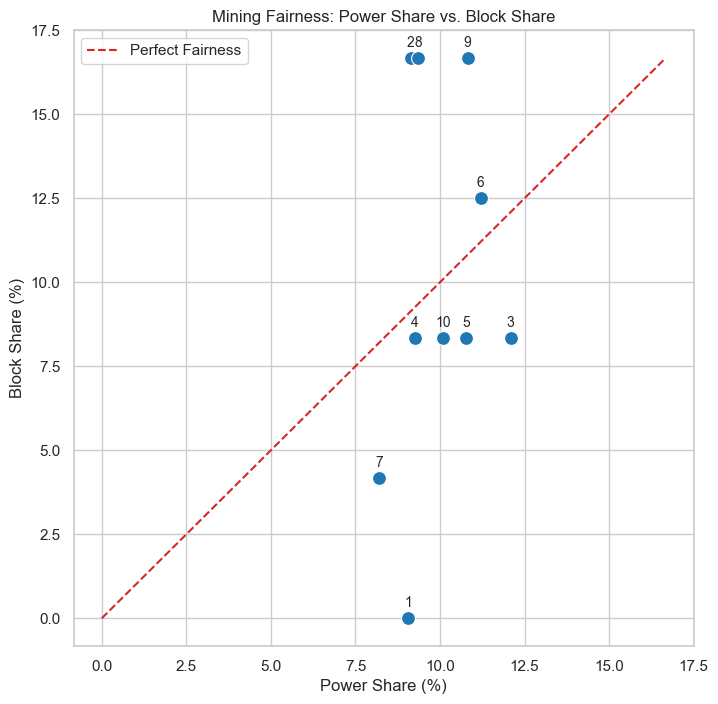

In [38]:
# Calculate Total Power and Blocks won per miner
total_power_per_miner = df_temp.groupby('miner')['power'].sum()
total_system_power = total_power_per_miner.sum()
power_share = (total_power_per_miner / total_system_power) * 100

blocks_won = df_blockchain['winner_miner'].value_counts()
total_blocks = len(df_blockchain)
block_share = (blocks_won / total_blocks) * 100

# Align indices
fairness_df = pd.DataFrame({'Power Share (%)': power_share, 'Block Share (%)': block_share}).fillna(0)

plt.figure(figsize=(8, 8))
sns.scatterplot(data=fairness_df, x='Power Share (%)', y='Block Share (%)', s=100, color='tab:blue')

# Annotate each point with the miner ID
for miner, row in fairness_df.iterrows():
    # Extract just the number from the miner ID
    label = miner.split('_')[-1]
    
    plt.annotate(label, 
                (row['Power Share (%)'], row['Block Share (%)']),
                textcoords="offset points", 
                xytext=(0, 8), # Position the text 8 points above the dot
                ha='center', 
                fontsize=10
                )
    
# Draw a 45-degree line for perfect fairness
plt.plot([0, fairness_df.max().max()], [0, fairness_df.max().max()], '--', label='Perfect Fairness', color='tab:red')
plt.title('Mining Fairness: Power Share vs. Block Share')
plt.legend()
plt.grid(True)
plt.show()

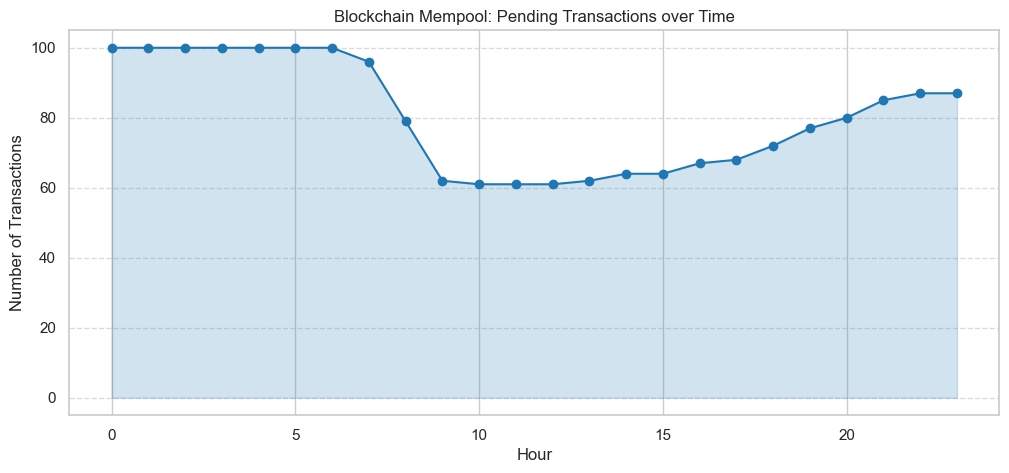

In [39]:
plt.figure(figsize=(12, 5))
plt.plot(df_blockchain['hour'], df_blockchain['num_pending_transactions'], marker='o', color='tab:blue')
plt.fill_between(df_blockchain['hour'], df_blockchain['num_pending_transactions'], alpha=0.2, color='tab:blue')
plt.title('Blockchain Mempool: Pending Transactions over Time')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()